In [1]:
import random
import warnings
from collections import Counter
from typing import List, Tuple

import numpy as np
import torch
from torch import nn, optim
from tqdm.auto import tqdm, trange

warnings.filterwarnings("ignore")

In [2]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
!unzip text8.zip
!rm text8.zip #удаление text8.zip (так как после распаковки он остается тоже)

--2024-01-22 17:34:09--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.117, 52.217.237.8, 52.216.42.184, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  28.9MB/s    in 1.0s    

2024-01-22 17:34:11 (28.9 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


In [3]:
with open("text8") as f:
    text = f.read()

print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


In [4]:
!wget https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2022/seminars/sem08/utils.py

--2024-01-22 17:34:12--  https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2022/seminars/sem08/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1511 (1.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   1.48K  --.-KB/s    in 0s      

2024-01-22 17:34:12 (15.0 MB/s) - ‘utils.py’ saved [1511/1511]



In [5]:
import utils # лежит здесь https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/08.%20Word2Vec/utils.py

words = utils.preprocess(text)
print(f"Beginning of the text: {words[:30]}")
print(f"Total words in text: {len(words)}")
print(f"Unique words: {len(set(words))}")

Beginning of the text: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']
Total words in text: 16680599
Unique words: 63641


In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
words_from_int = [int_to_vocab[idx] for idx in int_words]

print(int_words[:30])
print(words_from_int[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [7]:
threshold = 1e-5
word_counts = Counter(int_words)  # dictionary with number of appearances for each word
print(f"42-th word appears in the text {word_counts[42]} times")

# discard some frequent words, according to the subsampling method
# create a new list of words for training

train_words = []

for i in tqdm(int_words):
  rnd = np.random.uniform(0, 1)
  cnt = word_counts[i]
  p = np.sqrt(threshold / (cnt / len(int_words))) # без 1 - это вероятность оставления слова, а 1 - np.sqrt(threshold / (cnt / len(int_words))) - удаления
  if rnd < p:
    train_words.append(i)

print(train_words[:10])

words_from_int_train = [int_to_vocab[idx] for idx in train_words[:10]]
print(words_from_int_train)

42-th word appears in the text 32433 times


  0%|          | 0/16680599 [00:00<?, ?it/s]

[5233, 3080, 741, 10571, 133, 27349, 15067, 58112, 3580, 10712]
['anarchism', 'originated', 'working', 'radicals', 'including', 'diggers', 'sans', 'culottes', 'whilst', 'pejorative']


In [8]:
len(train_words)

4628032

In [9]:
def get_target(words: List[int], idx: int, window_size: int = 5) -> List[int]:
    """
    Get a list of words in a random-sized window around an index.

    :param words: a text represented as a sequence of words indices
    :param idx: index of the central word that is used to make a batch
    :param window_size: controls the size of the window for each word
    :return: list of words in a window of a window_size size
    """
    r = np.random.randint(1, window_size)
    target = (words[max(0, idx-r) : idx] + words[idx+1 : min(len(words), idx+r+1)])
    return target

In [10]:
# test your code!
# run this cell multiple times to check for random window selection
# you should get some indices around the idx

int_text = [i for i in range(10)]
idx = 5
target = get_target(int_text, idx=idx, window_size=5)
print("Input: ", int_text)
print(f"Index of interest: {idx}")
print("Target: ", target)

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Index of interest: 5
Target:  [4, 6]


In [11]:
def get_batches(
    words: List[int], batch_size: int, window_size: int = 5
) -> Tuple[List[int], List[int]]:
    """
    Create a generator of word batches as a tuple (inputs, targets)
    """
    for i in range(0, len(words) // batch_size * batch_size, batch_size):
        x, y = [], []
        batch = words[i : i + batch_size]
        for j in range(len(batch)):
            batch_x = batch[j]
            batch_y = get_target(words, i + j, window_size)
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x, y

In [12]:
int_text = [5233, 3080, 11, 5, 194, 1, 3133, 45, 58]
batch_gen = get_batches(int_text, batch_size=4, window_size=5)
x, y = next(batch_gen)

print(f"x: {x}")
print(f"y: {y}\n")

x, y = next(batch_gen)

print(f"x: {x}")
print(f"y: {y}\n")

x: [5233, 3080, 3080, 11, 11, 11, 11, 11, 5, 5, 5, 5]
y: [3080, 5233, 11, 5233, 3080, 5, 194, 1, 3080, 11, 194, 1]

x: [194, 194, 194, 194, 1, 1, 3133, 3133, 3133, 3133, 3133, 3133, 45, 45]
y: [11, 5, 1, 3133, 194, 3133, 11, 5, 194, 1, 45, 58, 3133, 58]



### демонстрация работы nn.Embedding

In [13]:
# word cat dog back

In [14]:
x = torch.LongTensor(np.array((0, 1, 2, 3), dtype='int32'))

In [15]:
emb = nn.Embedding(4, 2)
res = emb(x)
res

tensor([[-0.9636,  0.1718],
        [-1.1224,  0.6511],
        [-0.0296, -1.9984],
        [ 0.4124,  0.0629]], grad_fn=<EmbeddingBackward0>)

### продолжение (модель + обучение)

In [16]:
def cosine_similarity(
    embedding: nn.Module,
    valid_size: int = 16,
    valid_window: int = 100,
    device: str = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes cosine similarity between validation words and words in the embedding matrix.

    :param embedding: instance of torch.nn.Embedding module
    :param valid_size: number of words to find closest words to
    :param valid_window: number of words to draw examples from
    :param device: device to execute computations on
    :return: tensor of validation examples indices and tensor similarities to closest words
    """

    # Here we're calculating the cosine similarity between some random words and
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.

    # sim = (a . b) / |a||b|

    embed_vectors = embedding.weight

    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)

    # pick N words from our ranges (0, window) and (1000, 1000 + window). lower id implies more frequent
    valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
    valid_examples = np.append(
        valid_examples, random.sample(range(1000, 1000 + valid_window), valid_size // 2)
    )
    valid_examples = torch.LongTensor(valid_examples).to(device)

    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t()) / magnitudes

    return valid_examples, similarities

In [17]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_size) # активация после эмбеддинга не нужна, так как он просто кодирует слова (слово --> его вектор)
        self.linear = nn.Linear(embed_size, vocab_size)
    def forward(self, x: torch.Tensor):
        out = self.linear(self.emb(x))
        return out

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print_every = 1000
steps = 0
n_epochs = 5 # the more, the better
batch_size = 1024
embedding_dim = 128

model = SkipGram(len(vocab_to_int), embedding_dim)
model.to(device)
criterion = nn.CrossEntropyLoss() # because the task is simple classification
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)

for e in trange(n_epochs, leave=True, desc="Epoch number"):
    pbar = tqdm(
        get_batches(train_words, batch_size),
        leave=False,
        desc="Batch number",
        total=len(train_words) // batch_size,
    )

    # get input and target batches
    for inputs, targets in pbar:
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)

        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:
            # getting examples and similarities
            valid_examples, valid_similarities = cosine_similarity(model.emb, device=device)
            _, closest_idxs = valid_similarities.topk(5) # torch.topk() - k largest ones
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')

            for ii, valid_idx in enumerate(valid_examples):
                    closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                    print(int_to_vocab[valid_idx.item()] + " | " + ", ".join(closest_words))
            print("...")

Epoch number:   0%|          | 0/5 [00:00<?, ?it/s]

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

four | aladdin, freudian, triskelion, franc
five | inquires, elucidation, think, liv
two | rehabilitation, maldives, norbert, attained
has | shogun, recipient, restitution, ramesh
would | swollen, baseball, blanks, dinky
history | clausius, unusually, damp, stepney
seven | underneath, strathclyde, quarterfinal, scriptural
people | malformation, bnd, vater, swapped
report | mandinka, affonso, xiang, yaqub
derived | monotheism, buddhism, sidemen, testimonies
governor | blowing, journeymen, contacted, spoke
liberal | preparation, lifestyle, pedestrian, sarris
lived | beat, pili, whitacre, gi
consists | anwar, epilepsy, sarmatians, haunted
institute | het, goalscorer, avars, bet
operating | broadcasts, overwritten, vulva, tilsit
...
five | inquires, two, elucidation, ionians
d | particuarly, polypeptide, haida, curdling
used | ambrogio, pantheist, polymorphism, underlined
for | interview, minocycline, curricular, consulars
who | officiated, coca, seemed, sphincter
during | ruin, relied, ex

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

during | shalom, illegality, relied, obstruct
war | lasted, siege, sino, fictive
used | endangering, ambrogio, scanning, spores
b | musician, comedian, confidential, snooker
zero | two, four, one, six
who | officiated, unattractive, seemed, anic
have | slanted, goldman, deeper, sturdy
first | bedded, bottlenose, updating, townsfolk
animals | hanrahan, deciduous, exploiting, woven
marriage | executions, debts, outrageously, reunited
smith | welling, bloch, tek, nix
applications | precise, kernel, mnemonics, customers
dr | skilling, bef, deacon, herbst
running | allowing, beeb, jemima, downloadable
engineering | home, elca, university, memetic
grand | artur, stridently, jsf, flourishes
...
where | centimetre, gomez, eretz, gath
they | do, more, deterioration, osteoblasts
one | two, eight, six, zero
two | five, one, four, three
at | tni, lecompton, vancouver, hairs
was | king, baracoa, maharaja, persia
are | referring, medications, deficient, hygiene
been | admire, events, limiting, disci

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

was | were, had, he, returned
see | main, monoid, article, vl
at | lecompton, graduating, durango, high
used | uses, etc, malleability, implants
not | that, they, if, repent
its | impoverishment, commercially, fortifications, drips
years | male, age, median, two
these | have, russification, eloquence, established
test | tests, ortho, toxic, layer
hit | hitting, hits, hitter, catching
arts | universities, martial, traditional, ming
http | htm, www, edu, geocities
report | xiang, mihai, investigate, summary
applied | discovery, apply, misdiagnosed, ideologies
consists | unicameral, chamber, borough, councils
square | wires, cupola, timbered, housing
...
only | to, not, each, appended
new | york, seminary, accomplishments, longwood
that | not, because, this, they
history | mikkelson, external, timeline, see
he | his, him, she, had
into | donor, conquests, carbohydrates, partitioned
one | eight, seven, nine, six
has | have, in, decnet, more
orthodox | churches, christians, orthodoxy, const

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

however | but, not, have, they
has | have, significant, similarity, lineages
they | that, not, them, do
used | commonly, uses, use, abbreviated
only | not, to, but, that
nine | one, seven, eight, two
over | total, approximately, years, occurred
a | with, the, easily, is
powers | exercised, executive, dissolving, governed
square | kilometer, mile, kilometre, length
san | francisco, marcos, jose, diego
additional | fees, fcc, gratis, downsized
channel | cable, channels, upn, affiliate
account | accounts, devoured, scholars, mentions
active | arrived, group, jamaica, instituting
universe | cosmology, planets, worlds, physical
...
eight | one, seven, six, four
more | than, larger, less, with
be | ordinary, that, can, not
when | move, too, immediately, only
between | the, dividing, across, except
of | the, and, in, see
see | list, article, history, external
are | some, other, have, usually
rise | developments, proletariat, modernism, demand
cost | costs, expensive, price, zilog
professional

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

will | would, give, to, could
or | is, usually, often, depending
history | historical, external, timeline, prehistory
people | living, speak, americans, atheists
be | that, not, must, can
the | of, which, in, and
they | them, their, not, that
time | during, ever, record, next
marriage | marriages, marry, divorce, married
taking | bodyline, concomitant, setback, effectually
ice | frozen, hockey, arctic, glaciers
pre | cultures, eras, contemporaneous, merneptah
consists | consist, consisting, each, separate
grand | dukes, duke, duchy, prix
know | we, what, want, really
hit | hits, hitting, batters, outfield
...
an | a, is, as, addition
seven | one, eight, six, four
war | allied, wwii, troops, civil
use | used, such, inexpensive, modern
for | a, defaults, addition, only
the | of, a, in, and
four | three, five, two, six
state | states, statewide, legislature, confederal
gold | silver, copper, minted, ore
rise | rising, proletariat, revolution, recession
pre | cultures, standardise, eras, l

### check our model

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [21]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.emb.weight.to("cpu").data.numpy()

In [22]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

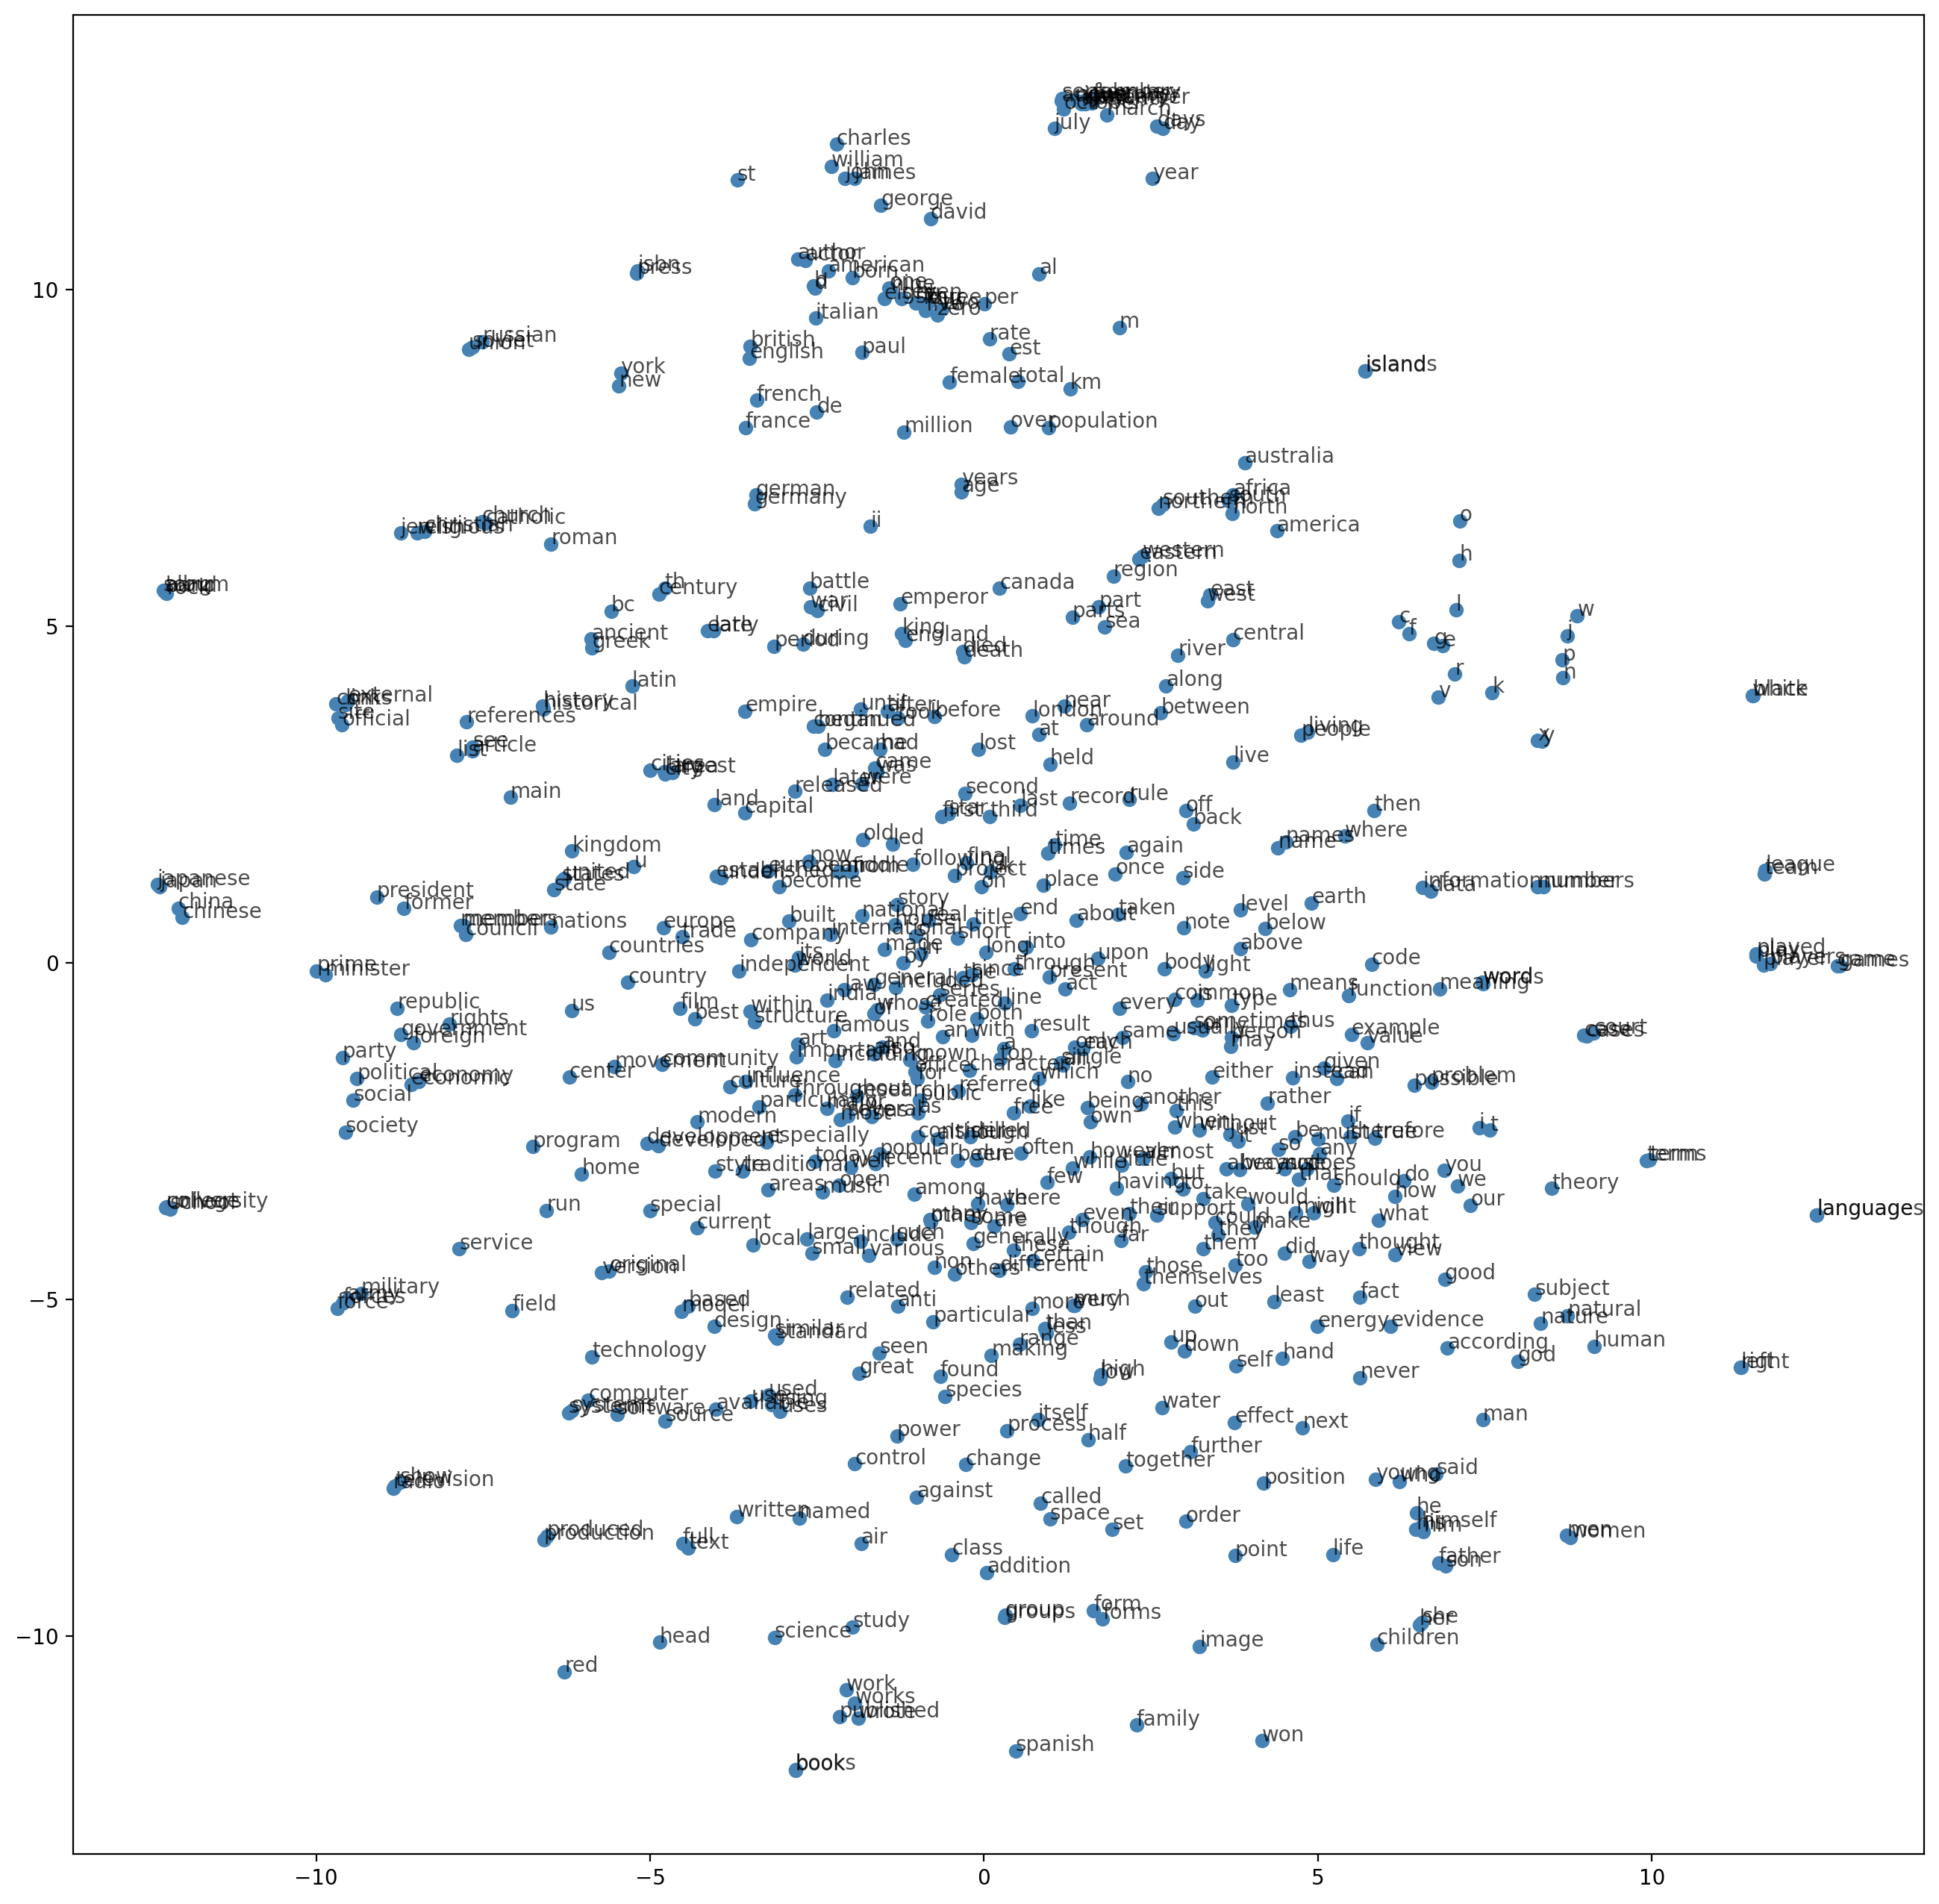

In [23]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color="steelblue")
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

### how to do it more clearly and easy (sota library --> gensim)

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.train([["hello", "world"]], total_examples=1, epochs=1)

vector = model.wv['computer']  # get numpy vector of a word
sims = model.wv.most_similar('computer', topn=10)  # get other similar words